In [1]:
import torch
import time 
import math
import torch.nn as nn
from torch import optim
import numpy as np
from IPython import display
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt 

In [2]:
def set_figsize(figsize=(3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

In [3]:
def train_2d(trainer):
    x1,x2,s1,s2 = -5, -2, 0, 0
    result = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        result.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f'%(i+1, x1, x2))
    return result        

In [4]:
def show_trace_2d(f, result):
    plt.plot(*zip(*result), '-o', color = '#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1,x2), colors = '#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

In [5]:
def f_2d(x1,x2):
    return 0.1*x1**2+2*x2**2
def gd_2d(x1,x2,s1,s2):
    return(x1-eta*0.2*x1,x2-eta*4*x2, 0, 0)

epoch 20, x1 -0.943467, x2 -0.000073


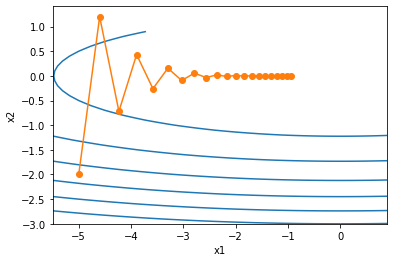

In [6]:
# 随机梯度下降
eta = 0.4
show_trace_2d(f_2d, train_2d(gd_2d))

In [8]:
def momentum_2d(x1,x2,v1,v2):
    v1 = gamma*v1+eta*0.2*x1
    v2 = gamma*v2+eta*4*x2
    return (x1-v1, x2-v2, v1, v2)

epoch 20, x1 -0.023863, x2 -0.016325


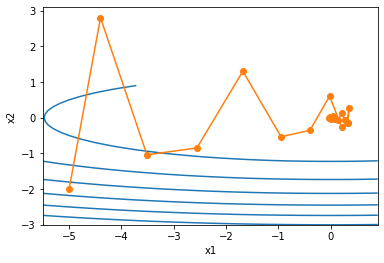

In [9]:
# 动量法
eta, gamma = 0.6, 0.6
show_trace_2d(f_2d, train_2d(momentum_2d))

In [10]:
def adagrad_2d(x1,x2,s1,s2):
    g1, g2, eps = 0.2*x1, 4*x2, 1e-6
    s1 += g1**2                      #每一步更新状态
    s2 += g2**2                      
    x1 -= eta/math.sqrt(s1+eps)*g1   #利用状态来更新梯度
    x2 -= eta/math.sqrt(s2+eps)*g2   
    return x1,x2,s1,s2

epoch 20, x1 -0.002295, x2 -0.000000


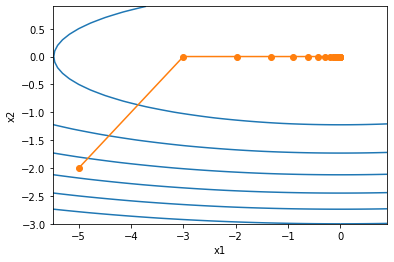

In [11]:
# adagrad算法
eta= 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

In [126]:
def RMSProp_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2*x1, 4*x2, 1e-6 
    #更新状态
    s1 = gamma*s1 + (1-gamma)*g1**2
    s2 = gamma*s2 + (1-gamma)*g2**2
    x1 -= eta*g1/(math.sqrt(s1+eps))
    x2 -= eta*g2/(math.sqrt(s2+eps))
    return x1,x2,s1,s2    

epoch 20, x1 -0.010599, x2 0.000000


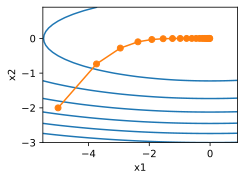

In [132]:
# RMSProp算法
gamma, eta = 0.9, 0.4
show_trace_2d(f_2d, train_2d(RMSProp_2d))

In [164]:
def train_delta_2d(trainer):
    x1,x2,s1,s2,delta_x1, delta_x2 = -5, -2, 0, 0, 0, 0
    result = [(x1, x2)]
    for i in range(2000):
        x1, x2, s1, s2, delta_x1, delta_x2 = trainer(x1, x2, s1, s2, delta_x1, delta_x2)
        result.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f'%(i+1, x1, x2))
    return result  
def AdaDelta_2d(x1, x2, s1, s2, delta_x1, delta_x2):
    g1, g2, eps = 0.2*x1, 4*x2, 1e-6
    s1 = pro*s1 + (1-pro)*g1**2
    s2 = pro*s2 + (1-pro)*g2**2
    g1_prime = math.sqrt((delta_x1+eps/s1+eps))*g1
    g2_prime = math.sqrt((delta_x2+eps/s2+eps))*g2
    delta_x1 = pro*delta_x1 + (1-pro)*g1_prime**2
    delta_x2 = pro*delta_x2 + (1-pro)*g2_prime**2
    x1 -= g1_prime
    x2 -= g2_prime
    return x1, x2, s1, s2, delta_x1, delta_x2

epoch 2000, x1 -1.648126, x2 -0.000500


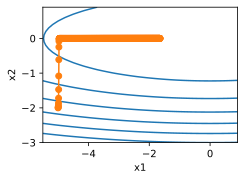

In [165]:
# AdaDelta算法
pro = 0.95
show_trace_2d(f_2d, train_delta_2d(AdaDelta_2d))

In [12]:
def get_data_ch7():
    data = np.genfromtxt('./Dataset/AirfoilNoise/airfoil_self_noise.dat', delimiter = '\t')
    data = (data-data.mean(axis=0))/data.std(axis=0)
    return (torch.tensor(data[:1500,:-1],dtype = torch.float),torch.tensor(data[:1500, -1],dtype = torch.float))

## Implement from Scratch for Momentum

In [16]:
def init_momentum_states(feature):
    v_w = torch.zeros((features.shape[-1], 1), dtype = torch.float)
    v_b = torch.zeros(1, dtype = torch.float)
    return (v_w, v_b)

def linreg(feature,w,b):
    label_hat = torch.mm(feature, w)+b
    return label_hat   

def squared_loss(label_hat, label):
    squ_loss = (((label_hat - label.view(label_hat.shape))**2)/2).mean()
    return squ_loss

def sgd_momentum(params, states, hyperparams):
    for param, state in zip(params,states):
        state.data = hyperparams['gamma']*state.data+hyperparams['lr']*param.grad.data
        param.data -= state.data

In [17]:
def train_loop(states, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn, optimizer_fn):
    
    #设定参数
    w = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size = (features.shape[1], 1)), dtype = torch.float), requires_grad = True)
    b = nn.Parameter(torch.zeros(1, dtype = torch.float), requires_grad = True)
    
    #返回初始误差
    def eval_loss():
        return loss_fn(model(features, w, b), labels).item()
    
    loss_list = [eval_loss()]
   
    #切割数据集
    tensor_data = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(tensor_data, batch_size, shuffle = True)
    
    #开始训练循环
    for _ in range(num_epoches):
        #记录起始时间
        start = time.time()
        for batch_i,(train_feature, train_label) in enumerate(data_iter):
            loss = loss_fn(model(train_feature, w, b), train_label)
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            loss.backward()
            
            optimizer_fn([w, b], states, hyperparams)
            if (batch_i+1)*batch_size%100 == 0:
                loss_list.append(eval_loss())        

    #打印结果画出损失图
    print('loss: %f, %f sec per epoch'%(loss_list[-1], time.time()-start))
    set_figsize()
    plt.plot(np.linspace(0, num_epoches, len(loss_list)), loss_list, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [29]:
features, labels = get_data_ch7()
hyperparams = {'gamma':0.5,'lr':0.05}
batch_size = 50
num_epoches = 10

loss: 0.242317, 0.031242 sec per epoch


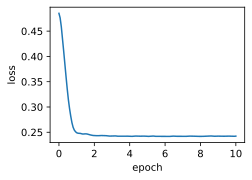

In [34]:
train_loop(init_momentum_states(features), hyperparams, features, labels, batch_size, num_epoches, linreg, squared_loss, sgd_momentum)

## Brief Achievement for Momentum

In [14]:
def train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn):
    #初始化优化器参数
    optimizer =  optimizer_fn(model.parameters(), **hyperparams)
    
    #返回初始误差
    def eval_loss():
        return loss_fn(model(features).view(-1), labels).item()/2

    loss_list = [eval_loss()]
   
    #切割数据集
    tensor_data = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(tensor_data, batch_size, shuffle = True)
    
    #开始训练循环
    for _ in range(num_epoches):
        #记录起始时间
        start = time.time()
        for batch_i,(train_feature, train_label) in enumerate(data_iter):
            loss = loss_fn(model(train_feature).view(-1), train_label)/2
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch_i+1)*batch_size%100 == 0:
                loss_list.append(eval_loss())        

    #打印结果画出损失图
    print('loss: %f, %f sec per epoch'%(loss_list[-1], time.time()-start))
    set_figsize()
    plt.plot(np.linspace(0, num_epoches, len(loss_list)), loss_list, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [15]:
# 获取数据
features, labels = get_data_ch7()
# 定义模型
model = nn.Sequential(nn.Linear(features.shape[-1],1))
# 定义损失函数
loss_fn = nn.MSELoss()
# 定义优化器
optimizer_fn = optim.SGD  
# 定义超参数
hyperparams = {'lr':0.01, 'momentum':0.9}
batch_size = 50
num_epoches = 10

loss: 0.242037, 0.015621 sec per epoch


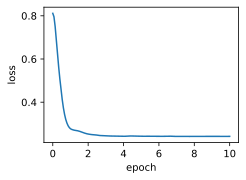

In [16]:
train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn)

## Implement from Scratch for Adagrad

In [138]:
def init_adagrad_states(features):
    s_w = torch.zeros((features.shape[-1],1),dtype = torch.float)
    s_b = torch.zeros(1, dtype = torch.float)
    return (s_w, s_b)
def adagrad(params, states, hyperparams):
    eps = 1e-6    
    for param, state in zip(params, states):
        state.data += param.grad.data**2
        param.data -= hyperparams['lr']*param.grad.data/torch.sqrt(state+eps)
def linreg(features, w, b):
    labels = torch.mm(features,w)+ b
    return labels
def loss_mse(label_hat, label):
    squ_loss = (((label_hat - label.view(label_hat.shape))**2)/2).mean()
    return squ_loss

In [143]:
def train_loop(features, labels, init_state, linreg, loss_mse, optimal_method, batch_size, num_epoches, hyperparams):
    w = torch.tensor(np.random.normal(0,0.01,size=(features.shape[-1],1)), dtype = torch.float, requires_grad = True) #并不用加Parameter
    b = torch.zeros(1, dtype = torch.float, requires_grad = True)    #加Parameter只是将该参数加入到nn.module类中
    states = init_state(features)

    # 误差计算函数
    def eval_loss():
        return loss_mse(linreg(features, w, b), labels).item()
    loss_list = [eval_loss()]

    # 打包数据集
    tensor_data = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(tensor_data, batch_size)

    #training loop
    for _ in range(num_epoches):
        start = time.time()
        for i, (train_features, train_labels) in enumerate(data_iter):
            train_label_hat = linreg(train_features, w, b)
            train_loss = loss_mse(train_label_hat.view(-1), train_labels)
        
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
        
            train_loss.backward()
        
            optimal_method((w,b), states, hyperparams)
            # 添加训练误差
            if ((i+1)*batch_size)%100 == 0:
                loss_list.append(eval_loss())
        end = time.time()

    # 训练过程绘图
    print('{}s per epoch, loss : {}'.format(end-start, loss_list[-1]))
    set_figsize()
    plt.plot(np.linspace(0, num_epoches, len(loss_list)), loss_list,'-')
    plt.xlabel('train_process')
    plt.ylabel('loss')

In [119]:
features, labels = get_data_ch7()
batch_size = 50
num_epoches = 10
hyperparams = {'lr': 0.1}

0.031241178512573242s per epoch, loss : 0.24232783913612366


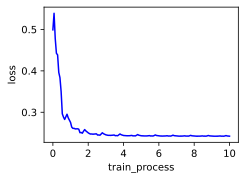

In [120]:
train_loop(features, labels, init_adagrad_states, linreg, loss_mse, adagrad, batch_size, num_epoches, hyperparams)

## Brief Achievement for Adagrad

In [124]:
optimizer_fn = torch.optim.Adagrad
hyperparams = {'lr':0.2}
batch_size = 50 
num_epoches = 10
model = nn.Linear(features.shape[-1], 1)
loss_fn = nn.MSELoss()

loss: 0.242071, 0.015621 sec per epoch


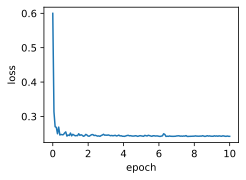

In [125]:
train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn)

## Implement for RMSProp from Scratch

In [140]:
def init_rmsprop_state(features):
    s_w = torch.zeros((features.shape[-1],1), dtype = torch.float)
    s_b = torch.zeros(1, dtype = torch.float)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eta, eps = hyperparams['gamma'], hyperparams['lr'],1e-6
    for param, state in zip(params, states):
        state.data = gamma*state.data + (1-gamma)*param.grad.data**2
        param.data -= eta*param.grad.data/torch.sqrt(state.data+eps)

In [147]:
features, labels = get_data_ch7()
hyperparams = {'lr': 0.01, 'gamma': 0.9}
init_state = init_rmsprop_state
optimal_method = rmsprop
batch_size = 50
num_epoches = 10

0.022938013076782227s per epoch, loss : 0.24304109811782837


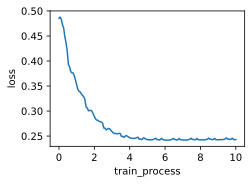

In [148]:
train_loop(features, labels, init_state, linreg, loss_mse, optimal_method, batch_size, num_epoches, hyperparams)

## Brief Achievement for RMSProp

In [149]:
features, labels = get_data_ch7()
hyperparams = {'lr': 0.01, 'alpha':0.9}
optimizer_fn = torch.optim.RMSprop
batch_size = 50
num_epoches = 10
model = nn.Linear(features.shape[-1], 1)
loss_fn = nn.MSELoss()

loss: 0.242245, 0.022938 sec per epoch


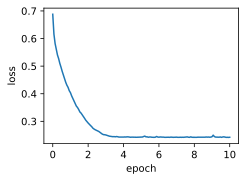

In [150]:
train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn)

## Implement for AdaDelta from Scratch

In [181]:
def init_adadelta_state(features):
    s_w = torch.zeros((features.shape[-1],1), dtype = torch.float)
    s_b = torch.zeros(1,dtype = torch.float)
    s_delta_w = torch.zeros_like(s_w, dtype = torch.float)    
    s_delta_b = torch.zeros_like(s_b, dtype = torch.float)
    return ((s_w, s_delta_w), (s_b,s_delta_b))

def adadelta(params, states, hyperparams):
    pro,eps = hyperparams['pro'], 1e-5
    for param, (state, delta_state) in zip(params, states):
        state.data = pro*state.data +(1-pro)*(param.grad.data**2)
        prime = param.grad.data*torch.sqrt((delta_state.data+eps)/(state.data+eps))
        param.data -= prime 
        delta_state.data = pro*delta_state.data + (1-pro)*prime**2

In [182]:
features, labels = get_data_ch7()
hyperparams = {'pro': 0.9}
init_state = init_adadelta_state
optimal_method = adadelta
batch_size = 50
num_epoches = 10

0.031239748001098633s per epoch, loss : 0.24203860759735107


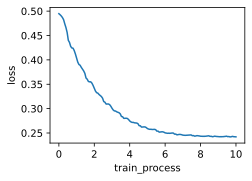

In [183]:
train_loop(features, labels, init_state, linreg, loss_mse, optimal_method, batch_size, num_epoches, hyperparams)

   ## Brief Achievement for AdaDelta

In [184]:
features, labels = get_data_ch7()
hyperparams = {'rho':0.9}
optimizer_fn = torch.optim.Adadelta
batch_size = 50
num_epoches = 10
model = nn.Linear(features.shape[-1], 1)
loss_fn = nn.MSELoss()

loss: 0.242051, 0.015621 sec per epoch


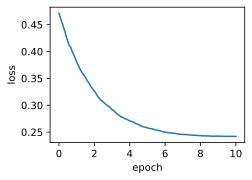

In [185]:
train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn)

## Implement for Adam from Scratch

In [190]:
def init_adam_states(features):
    s_w = torch.zeros((features.shape[-1],1), dtype = torch.float)
    s_b = torch.zeros(1,dtype = torch.float)
    v_w = torch.zeros_like(s_w, dtype = torch.float)    
    v_b = torch.zeros_like(s_b, dtype = torch.float)
    return ((s_w, v_w), (s_b,v_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for param, (state, momentum) in zip(params, states):
        momentum.data = beta1*momentum.data + (1-beta1)*param.grad.data
        state.data =beta2*state.data + (1-beta2)*param.grad.data**2
        m_bias_corr = momentum.data/(1-beta1**hyperparams['t'])
        s_bias_corr = state.data/(1-beta2**hyperparams['t'])
        param.data -= hyperparams['lr']*m_bias_corr/(torch.sqrt(s_bias_corr)+eps)
    hyperparams['t'] += 1

In [191]:
features, labels = get_data_ch7()
hyperparams = {'lr': 0.01, 't':1}
init_state = init_adam_states
optimal_method = adam
batch_size = 50
num_epoches = 10

0.03124213218688965s per epoch, loss : 0.2421102672815323


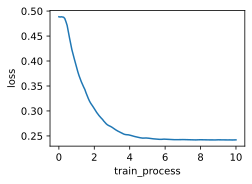

In [192]:
train_loop(features, labels, init_state, linreg, loss_mse, optimal_method, batch_size, num_epoches, hyperparams)

## Brief Achievement for AdaDelta

In [193]:
features, labels = get_data_ch7()
hyperparams = {'lr':0.01}
optimizer_fn = torch.optim.Adam
batch_size = 50
num_epoches = 10
model = nn.Linear(features.shape[-1], 1)
loss_fn = nn.MSELoss()

loss: 0.242966, 0.015621 sec per epoch


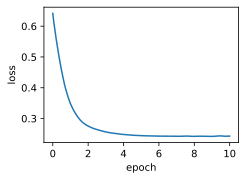

In [194]:
train_loop_pytorch(optimizer_fn, hyperparams, features, labels, batch_size, num_epoches, model, loss_fn)